In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.models as models
import os
import matplotlib.pyplot as plt
import cv2
import Augmentor
import shutil
import random

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Первым делом проверим количество наших данных

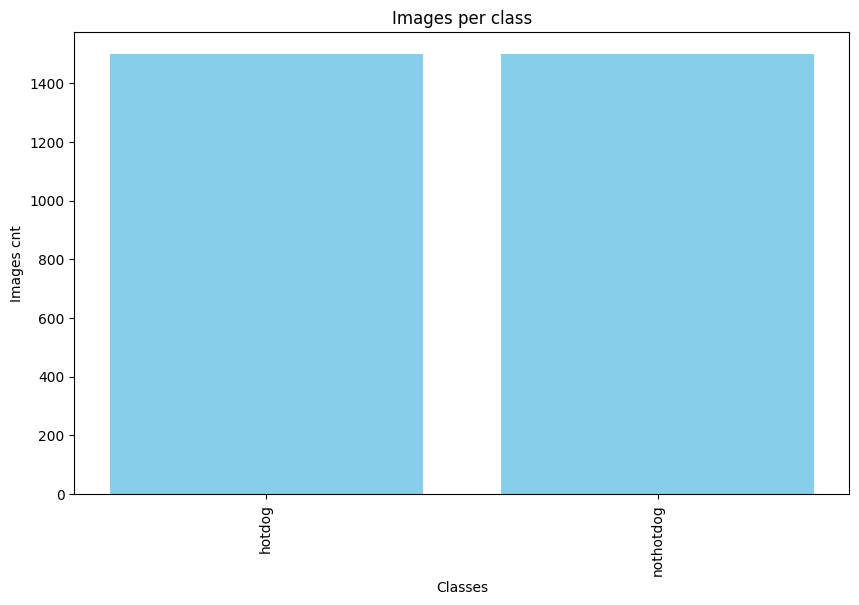

In [2]:
direct = os.listdir('train')
image_counts = []

for d in direct:
    folder_path = os.path.join("train", d)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        image_counts.append(len(images))

plt.figure(figsize=(10, 6))
plt.bar(direct, image_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Images cnt')
plt.title('Images per class')
plt.xticks(rotation=90)
plt.show()

Количество изображений одинаково, однако их не хватает. Добавим аугментаций, чтобы увеличить число данных. Расширим их с помощью Augmentor

Вытащим val из train и к train применим аугментацию

In [3]:
source_folder = 'train/hotdog'
destination_folder = 'val/hotdog'
files = os.listdir(source_folder)

n = 300
selected_files = random.sample(files, n)
for file_name in selected_files:
    source = os.path.join(source_folder, file_name)
    destination = os.path.join(destination_folder, file_name)
    shutil.move(source, destination)

source_folder_2 = 'train/nothotdog'
destination_folder_2 = 'val/nothotdog'
files = os.listdir(source_folder_2)

n = 300
selected_files = random.sample(files, n)

for file_name in selected_files:
    source = os.path.join(source_folder_2, file_name)
    destination = os.path.join(destination_folder_2, file_name)
    shutil.move(source, destination)

Теперь у нас 20% изображений идут на validation. Аугментируем их всех

In [4]:
p = Augmentor.Pipeline("train/hotdog", output_directory="../../aug_train/hotdog")
p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)
p.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)
p.sample(400)
p.process()

q = Augmentor.Pipeline("train/nothotdog", output_directory="../../aug_train/nothotdog")
q.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
q.flip_left_right(probability=0.5)
q.zoom_random(probability=0.5, percentage_area=0.9)
q.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)
q.flip_top_bottom(probability=0.5)
# Укажем количество изображений, которые необходимо сгенерировать
q.sample(400)  # Пример: сгенерировать 1000 аугментированных изображений
q.process()

Initialised with 1200 image(s) found.
Output directory set to train/hotdog\../../aug_train/hotdog.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x1F5681054F0>: 100%|██████████| 800/800 [00:01<00:00, 405.87 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x1F567B7FF20>: 100%|██████████| 1200/1200 [00:03<00:00, 396.20 Samples/s]                   


Initialised with 1200 image(s) found.
Output directory set to train/nothotdog\../../aug_train/nothotdog.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x1F5658EEDE0>: 100%|██████████| 800/800 [00:02<00:00, 365.61 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x1F567C83E00>: 100%|██████████| 1200/1200 [00:03<00:00, 361.14 Samples/s]                   


Теперь аугментированные тренировочные данные хранятся в папке aug_train, а валидационные в val